In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import math, copy, time
import os
import sys
import pandas as pd
import torchinfo

import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline

#import warnings
#warnings.filterwarnings("ignore")

import data_preprocess
import generate_dataset
import lstm_encoder_decoder
import plotting 
import data_valuator
import funtions_for_dvrl

matplotlib.rcParams.update({'font.size': 17})


#import plotting

import json
import pickle

device = torch.device("cuda")
torch.set_default_device(device)

## Data Preprocess

In [2]:
############ DATASET HYPER PARAMETERS #################
train_val_split = 0.9
lookback = 30
lookahead = 3
step = 1
batch_size = 45

### Data Baseline

Shape : (16208, 17), Data Type : object


<function matplotlib.pyplot.show(close=None, block=None)>

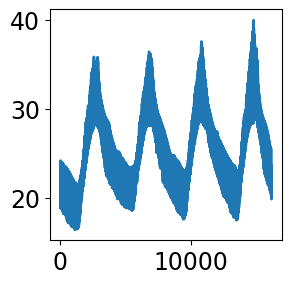

In [3]:
dataset, time_feature = data_preprocess.get_dataset()
print(f"Shape : {dataset.shape}, Data Type : {dataset.dtype}")
ith = 11                                                              # Decide Which Feature To Train On
plt.figure(figsize=(3, 3))
plt.plot(dataset[:,ith])
plt.show

Length Of New Avg Dataset:  383


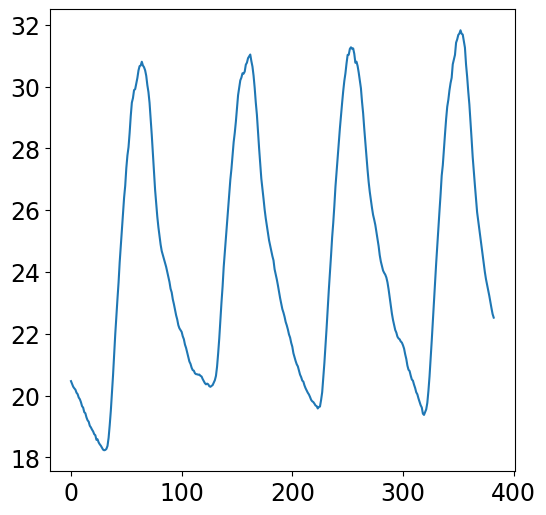

In [4]:
dataset[:, 0] = data_preprocess.time_feature_to_time(dataset[:,0])
prev_batch = '01'
new_data = []
j = 0
sums = 0
for i, batch in enumerate(dataset[:,0]):
    if batch == prev_batch:
        sums += dataset[i,11]
        j += 1
        prev_batch = batch
    elif batch != prev_batch:
        new_data.append(sums/j)
        sums = 0
        j = 0
        prev_batch = batch

print("Length Of New Avg Dataset: ", len(new_data))
plt.figure(figsize=(6, 6))
plt.plot(new_data)
plt.show

new_data_np = np.array(new_data)

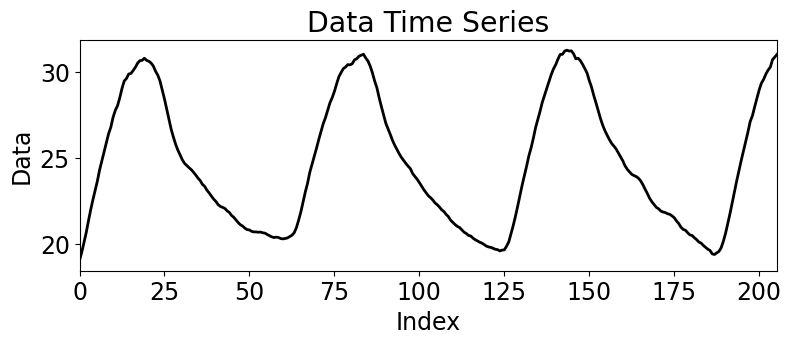

In [5]:
# y -> Actual Dataset, t -> Timesteps for Plotting
t_baseline, y_baseline = generate_dataset.synthetic_data(Nt=383)
#new_data_np = data_preprocess.scale_data(new_data_np)
t_train_baseline, data_train_baseline, t_val_baseline, data_val_baseline = generate_dataset.train_test_split(t_baseline, new_data_np[35:], split = train_val_split)

# plot time series 
plt.figure(figsize = (9, 3))
plt.plot(t_train_baseline, data_train_baseline, color = 'k', linewidth = 2)
plt.xlim([t_train_baseline[0], t_train_baseline[-1]])
plt.xlabel('Index')
plt.ylabel('Data')
plt.title('Data Time Series')
plt.savefig('plots/synthetic_time_series.png')


In [6]:
x_train_multi_baseline, y_train_multi_baseline = funtions_for_dvrl.multivariate_data(data_train_baseline, data_train_baseline, 0,
                                                 None, lookback,
                                                 lookahead, step)
x_val_multi_baseline, y_val_multi_baseline = funtions_for_dvrl.multivariate_data(data_val_baseline, data_val_baseline,
                                             0, None, lookback,
                                             lookahead, step)

print (
       'Train Dataset X Size : {}'.format(x_train_multi_baseline.shape),
       'Train Dataset Y Size : {}'.format(y_train_multi_baseline.shape),
       'Validation Dataset X Size : {}'.format(x_val_multi_baseline.shape),
       'Validation Dataset Y Size : {}'.format(y_val_multi_baseline.shape),
       sep='\n')

Train Dataset X Size : (280, 30, 1)
Train Dataset Y Size : (280, 3, 1)
Validation Dataset X Size : (2, 30, 1)
Validation Dataset Y Size : (2, 3, 1)


In [7]:
#Extracting a single column for univariante time series
x_train_baseline = torch.from_numpy(x_train_multi_baseline.squeeze(-1))
y_train_baseline = torch.from_numpy(y_train_multi_baseline.squeeze(-1))
x_valid_baseline = torch.from_numpy(x_val_multi_baseline)
y_valid_baseline = torch.from_numpy(y_val_multi_baseline)

x_valid_baseline = x_valid_baseline.transpose(1,0).float()
y_valid_baseline = y_valid_baseline.transpose(1,0).float()
print(f"X Train Shape : {x_train_baseline.shape}")
print(f"Y Train Shape : {y_train_baseline.shape}")
print(f"X Valid Shape : {x_valid_baseline.shape}")
print(f"Y Valid Shape : {y_valid_baseline.shape}")

X Train Shape : torch.Size([280, 30])
Y Train Shape : torch.Size([280, 3])
X Valid Shape : torch.Size([30, 2, 1])
Y Valid Shape : torch.Size([3, 2, 1])


In [8]:
x_train_baseline = x_train_baseline.to(device)
y_train_baseline = y_train_baseline.to(device)
x_valid_baseline = x_valid_baseline.to(device)
y_valid_baseline = y_valid_baseline.to(device)

### Data Corrupted

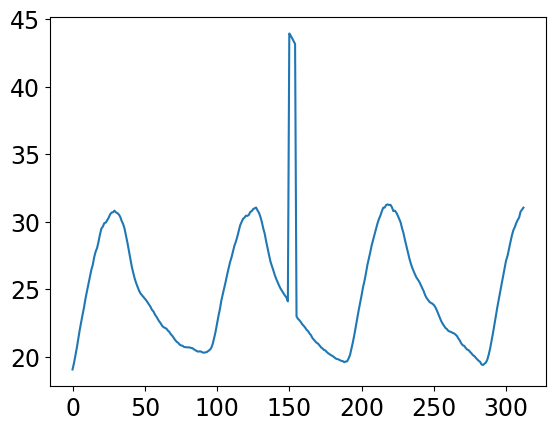

In [9]:
data_train_corrupt = data_train_baseline.copy()
data_train_corrupt[150:155] += 20
# data_train_corrupt[50] += 5
plt.plot(data_train_corrupt)
plt.show()

In [10]:
x_train_multi, y_train_multi = funtions_for_dvrl.multivariate_data(data_train_corrupt, data_train_corrupt, 0,
                                                 None, lookback,
                                                 lookahead, step)
index_val = np.random.randint(0, x_train_multi.shape[0], size=50)
print(f"Indices : {index_val}")
x_val_multi, y_val_multi = x_train_multi_baseline[index_val, :,:], y_train_multi_baseline[index_val, :, :]

print (
       'Train Dataset X Size : {}'.format(x_train_multi.shape),
       'Train Dataset Y Size : {}'.format(y_train_multi.shape),
       'Validation Dataset X Size : {}'.format(x_val_multi.shape),
       'Validation Dataset Y Size : {}'.format(y_val_multi.shape),
       sep='\n')

Indices : [ 64 155 151 215  56 103  84 195  95 153  32 245  74 140 126 267   8 270
  40  95 108 190 264  82  98 274 113 234 214 118 130 246 230  41   6 254
  53  83 183  41  66  40 133 253 167  94 168 267 185 119]
Train Dataset X Size : (280, 30, 1)
Train Dataset Y Size : (280, 3, 1)
Validation Dataset X Size : (50, 30, 1)
Validation Dataset Y Size : (50, 3, 1)


In [11]:
#Extracting a single column for univariante time series
x_train_corrupt = torch.from_numpy(x_train_multi.squeeze(-1))
y_train_corrupt = torch.from_numpy(y_train_multi.squeeze(-1))
x_valid_corrupt = torch.from_numpy(x_val_multi)
y_valid_corrupt = torch.from_numpy(y_val_multi)


x_valid_corrupt = x_valid_corrupt.transpose(1,0).float()
y_valid_corrupt = y_valid_corrupt.transpose(1,0).float()
print(f"X Train Shape : {x_train_corrupt.shape}")
print(f"Y Train Shape : {y_train_corrupt.shape}")
print(f"X Valid Shape : {x_valid_corrupt.shape}")
print(f"Y Valid Shape : {y_valid_corrupt.shape}")

X Train Shape : torch.Size([280, 30])
Y Train Shape : torch.Size([280, 3])
X Valid Shape : torch.Size([30, 50, 1])
Y Valid Shape : torch.Size([3, 50, 1])


In [12]:
x_train = x_train_corrupt.to(device)
y_train = y_train_corrupt.to(device)
x_valid = x_valid_corrupt.to(device)
y_valid = y_valid_corrupt.to(device)

## Training

### Train DVRL

In [13]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 256):
    "Helper: Construct a model1 from hyperparameters."

    model_1 = data_valuator.Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

In [14]:
model_1 = make_model()
model_1.to(device)
moving_avg_loss = torch.tensor(2)

In [15]:
torchinfo.summary(model_1, [(batch_size, lookback + lookahead)], dtypes=[torch.float64, torch.float64], col_names=["input_size", "output_size", 
                                                                                                 "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Data_Valuator_MLP                        [45, 33]                  [45, 1]                   --                        True
├─Sequential: 1-1                        [45, 33]                  [45, 1]                   --                        True
│    └─Linear: 2-1                       [45, 33]                  [45, 256]                 8,704                     True
│    └─LeakyReLU: 2-2                    [45, 256]                 [45, 256]                 --                        --
│    └─Linear: 2-3                       [45, 256]                 [45, 128]                 32,896                    True
│    └─LeakyReLU: 2-4                    [45, 128]                 [45, 128]                 --                        --
│    └─Linear: 2-5                       [45, 128]                 [45, 64]                  8,256                     True
│    └─

In [16]:
for p in model_1.parameters():
    p.requires_grad = True #False


mov_avg_plot = []
reward_plot = []
val_loss_plot = []
iteration = []
mean_of_hidden = []
mean_of_prob = []
train_loss_plot = []
lstm_predict_plot = []

In [17]:
## MLP MODEL

reward = 0
model_4 = lstm_encoder_decoder.lstm_seq2seq(input_size = 1, hidden_size = 128)
learning_rate_for_dve = 0.00001
learning_rate_for_lstm = 0.0001
time_window_size = 15
reward = -10
num_of_epochs = 100 
iters = 0
threshold = 0.9
epsilon = 1e-8
optim_for_dve = torch.optim.Adam(model_1.parameters(), lr=learning_rate_for_dve)
optim_for_lstm = optim.Adam(model_4.parameters(), lr = learning_rate_for_lstm)
criterion_for_lstm = funtions_for_dvrl.RMSELoss()

In [18]:
for i in range(num_of_epochs):
    print("###################################")
    for T in range(270):
        
        #Make Time Window Batches
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        inputs = torch.cat((x_batch,y_batch), 1).to(device)
        #inputs = PositionalEncoding(inputs)
        prob_vector, hid = model_1.forward(inputs)
        #if i == 0:
            #prob_vector = torch.ones(x_batch.shape[0],1)
        select = funtions_for_dvrl.SelectionFromProb_2(prob_vector)
        select_for_lstm = select.clone().detach().to(device)
        if torch.all(select_for_lstm == torch.zeros_like(select_for_lstm)):
            continue
        x_selected_batch, y_selected_batch = funtions_for_dvrl.SelectBatches(x_batch, y_batch, select_for_lstm)
        mean = torch.mean(prob_vector).clone().detach()
        # if torch.all(select==0).item():
        #     continue
        if T % 50== 0:
            print(f'Epoch = {i}')
            print(f'Iteration = {T}')
            print(f'Mean Of Prob Vector = {mean}')
            print(f'Prob Vector = {prob_vector}')
            # print(f'Mean Of Hidden Vector = {mean_hid}')
            # print(f'Hidden State Just Before Sigmoid = {hid}')
        #Reshape For LSTM
        x_selected_batch = torch.unsqueeze(x_selected_batch,2)
        x_selected_batch = x_selected_batch.transpose(1,0).float().detach()
        y_selected_batch = torch.unsqueeze(y_selected_batch,2)
        y_selected_batch = y_selected_batch.transpose(1,0).float().detach()
        #Pass Through LSTM
        loss = model_4.train_model(input_tensor=x_selected_batch, target_tensor=y_selected_batch, optimizer = optim_for_lstm, 
                                                 training_prediction = 'teacher_forcing', dynamic_tf = False)
        y_hat_valid = model_4.predict(x_valid, lookahead)
        val_loss = criterion_for_lstm(y_hat_valid,y_valid)
        #Update The Moving Average
        if iters > 1000:
            moving_avg_loss = funtions_for_dvrl.MAL(val_loss, iters+1+1-800, moving_avg_loss)
        #Determine The Log_Pi Loss And Reward Scale
        reward = moving_avg_loss - val_loss
        data_valuator_loss = funtions_for_dvrl.DataValuator_LogPi_2(select_for_lstm, prob_vector, epsilon, threshold, reward, explore_parameter=1e3)
        #Plot Everything
        # lstm_predict_plot.append(lstm_predict)
        train_loss_plot.append(loss)
        mov_avg_plot.append(moving_avg_loss)
        reward_plot.append(reward)
        val_loss_plot.append(val_loss)
        iteration.append(iters)
        iters+=1
        if T % 50 == 0:
            print(f"val_curr_loss = {val_loss}, dv_loss = {data_valuator_loss}, reward = {reward}, iters = {iters}")

        if iters < 12500:
            continue
        optim_for_dve.zero_grad()
        data_valuator_loss.backward()
        optim_for_dve.step()

###################################
Epoch = 0
Iteration = 0
Mean Of Prob Vector = 0.5215827822685242
Prob Vector = tensor([[0.5136],
        [0.5145],
        [0.5156],
        [0.5164],
        [0.5174],
        [0.5186],
        [0.5199],
        [0.5213],
        [0.5229],
        [0.5242],
        [0.5254],
        [0.5270],
        [0.5282],
        [0.5291],
        [0.5296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
val_curr_loss = 24.860960006713867, dv_loss = tensor([191.6850], device='cuda:0', grad_fn=<AddBackward0>), reward = -22.860960006713867, iters = 1
Epoch = 0
Iteration = 50
Mean Of Prob Vector = 0.5181315541267395
Prob Vector = tensor([[0.5199],
        [0.5197],
        [0.5194],
        [0.5191],
        [0.5187],
        [0.5185],
        [0.5184],
        [0.5182],
        [0.5179],
        [0.5177],
        [0.5175],
        [0.5172],
        [0.5169],
        [0.5166],
        [0.5164]], device='cuda:0', grad_fn=<SigmoidBackward0>)
val_curr_loss = 22.9235610

In [133]:
for i in range(len(mean_of_hidden)):
    mean_of_hidden[i] = mean_of_hidden[i].to("cpu")
for i in range(len(val_loss_plot)):
    val_loss_plot[i] = val_loss_plot[i].to("cpu")
for i in range(len(reward_plot)):
    reward_plot[i] = reward_plot[i].to("cpu")

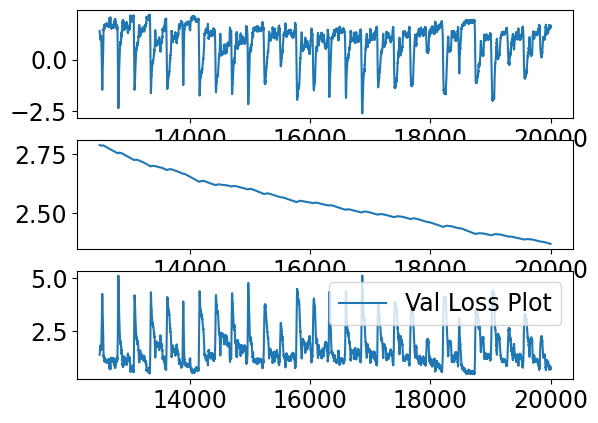

In [138]:
reward_plot_list = [tensor.cpu().detach() for tensor in reward_plot]
mov_avg_plot_list = [tensor.cpu().detach() for tensor in mov_avg_plot]
val_plot_list = [tensor.cpu().detach() for tensor in val_loss_plot]
iteration_plot_list = [tensor for tensor in iteration]
fig, axes = plt.subplots(3, 1)
axes[0].plot(iteration_plot_list[12500:20000], reward_plot_list[12500:20000], label="Reward Loss Plot")
axes[1].plot(iteration_plot_list[12500:20000], mov_avg_plot_list[12500:20000], label="Moving Avg Plot")
axes[2].plot(iteration_plot_list[12500:20000], val_plot_list[12500:20000], label="Val Loss Plot")
plt.legend()
plt.show()

In [19]:
inputt = torch.cat((x_train[:,:] ,y_train[:,:]), 1).to(device)
prob_vector, hid = model_1.forward(inputt)
print(prob_vector)

tensor([[0.2600],
        [0.2596],
        [0.2592],
        [0.2585],
        [0.2572],
        [0.2553],
        [0.2537],
        [0.2513],
        [0.2488],
        [0.2442],
        [0.2392],
        [0.2343],
        [0.2281],
        [0.2222],
        [0.2163],
        [0.2110],
        [0.2067],
        [0.2030],
        [0.1989],
        [0.1956],
        [0.1933],
        [0.1917],
        [0.1899],
        [0.1880],
        [0.1867],
        [0.1854],
        [0.1851],
        [0.1853],
        [0.1862],
        [0.1869],
        [0.1886],
        [0.1905],
        [0.1932],
        [0.1966],
        [0.2003],
        [0.2045],
        [0.2090],
        [0.2140],
        [0.2189],
        [0.2236],
        [0.2277],
        [0.2314],
        [0.2346],
        [0.2373],
        [0.2395],
        [0.2414],
        [0.2430],
        [0.2447],
        [0.2462],
        [0.2479],
        [0.2496],
        [0.2515],
        [0.2532],
        [0.2551],
        [0.2568],
        [0

In [20]:
for i,prob in enumerate(prob_vector):
    print(f"Index {i} has prob {prob}")

Index 0 has prob tensor([0.2600], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 1 has prob tensor([0.2596], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 2 has prob tensor([0.2592], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 3 has prob tensor([0.2585], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 4 has prob tensor([0.2572], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 5 has prob tensor([0.2553], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 6 has prob tensor([0.2537], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 7 has prob tensor([0.2513], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 8 has prob tensor([0.2488], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 9 has prob tensor([0.2442], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 10 has prob tensor([0.2392], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 11 has prob tensor([0.2343], device='cuda:0', grad_fn=<UnbindBackward0>)
Index 12 has prob tensor([0.2281], device='cuda:0', grad_fn=<U

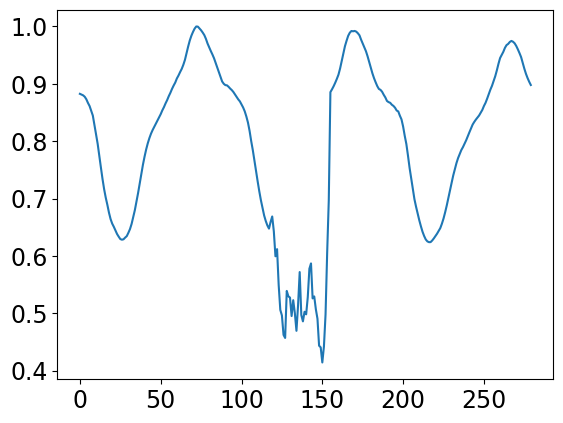

In [22]:
prob_vector_cpu = prob_vector.cpu().detach().numpy()
plt.plot(prob_vector_cpu/max(prob_vector_cpu))